In [1]:
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
# Widgets import
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import copy



%matplotlib inline

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
        features.append(file_features.tolist())
    # Return list of feature vectors
    return features
    

    
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
        
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(150, 64), xy_overlap=(0.8, 0.8)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    cp_heatmap = copy.deepcopy(heatmap)
    # Zero out pixels below the threshold
    cp_heatmap[cp_heatmap <= threshold] = 0
    # Return thresholded map
    return cp_heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [3]:
def detect_vehicles(img):
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255

#     y_start_stop = [395, None] # Min and max in y to search in slide_window()
#     windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(128, 128), xy_overlap=(0.75, 0.75))

    y_start_stop = [395, 650] # Min and max in y to search in slide_window()
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 96), xy_overlap=(0.5, 0.5))

    y_start_stop = [395, 650] # Min and max in y to search in slide_window()
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    y_start_stop = [395, 550] # Min and max in y to search in slide_window()
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(48, 48), xy_overlap=(0.45, 0.45))
    windows = windows2 + windows3 + windows4
#     windows = windows1 + windows2 + windows3 + windows4
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img, hot_windows, windows2, windows3, windows4

In [4]:
def read_training_data():
    vehicle_images = glob.glob('./data/vehicles/*/*.png')
    non_vehicle_images = glob.glob('./data/non-vehicles/*/*.png')
    return (vehicle_images, non_vehicle_images)

cars, notcars = read_training_data()

print("Done loading training filenames")
print("Number of car images: ", len(cars))
print("Number of non-car images: ", len(notcars))

Done loading training filenames
Number of car images:  8792
Number of non-car images:  8968


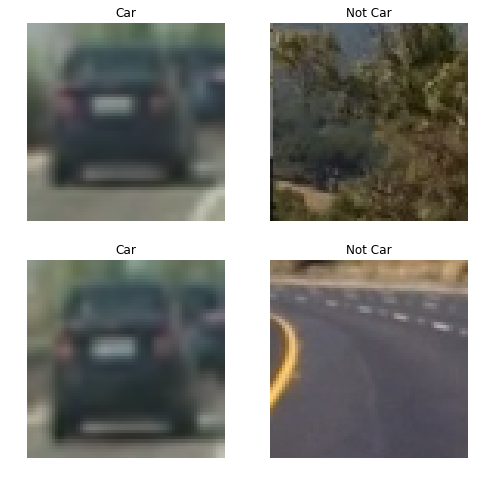

In [6]:
plt_rows = 2
plt_cols = 2
plt.subplots(plt_rows, plt_cols, figsize=(plt_cols*4, plt_rows*4))
for i in range(0, plt_rows * plt_cols):
    plt.subplot(plt_rows, plt_cols, i+1)
    if i % plt_cols < plt_cols/2:
        plt.title('Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(cars[i]))
    else:
        plt.title('Not Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(notcars[i]))

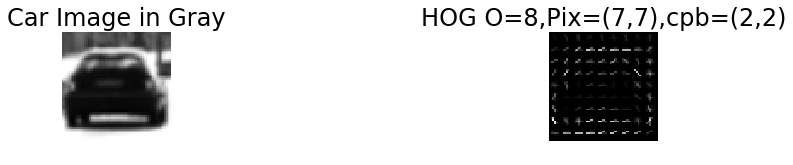

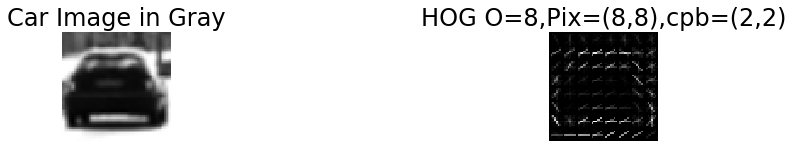

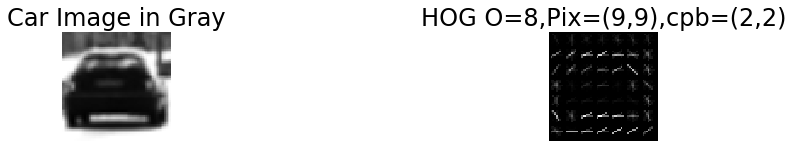

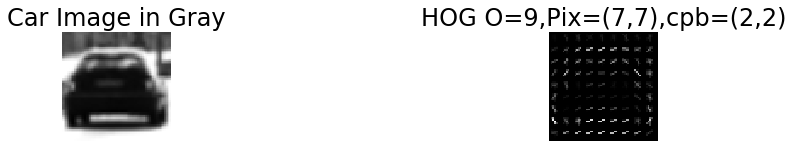

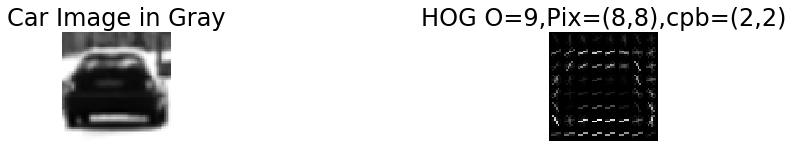

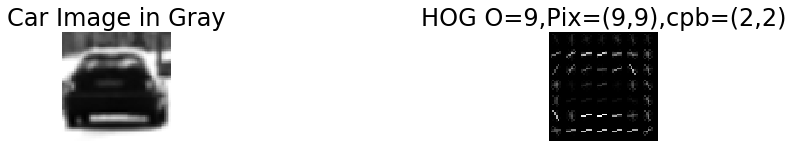

In [7]:
# Just for fun choose random car / not-car indices and plot example images   
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# work on grey scale image
car_image_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY) # convert to gray scale

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features_1, hog_image_1 = get_hog_features(car_image_gray, orient=8,pix_per_cell=7, cell_per_block=2,vis=True, feature_vec=False)
hog_features_2, hog_image_2 = get_hog_features(car_image_gray, orient=8,pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=False)
hog_features_3, hog_image_3 = get_hog_features(car_image_gray, orient=8,pix_per_cell=9, cell_per_block=2,vis=True, feature_vec=False)
hog_features_4, hog_image_4 = get_hog_features(car_image_gray, orient=9,pix_per_cell=7, cell_per_block=2,vis=True, feature_vec=False)
hog_features_5, hog_image_5 = get_hog_features(car_image_gray, orient=9,pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=False)
hog_features_6, hog_image_6 = get_hog_features(car_image_gray, orient=9,pix_per_cell=9, cell_per_block=2,vis=True, feature_vec=False)
# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features_1) 

# Plot the examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
ax1.axis('off')
ax1.set_title('Car Image in Gray', fontsize=24)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=8,Pix=(7,7),cpb=(2,2)', fontsize=24)
ax2.imshow(hog_image_1, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
ax1.axis('off')
ax1.set_title('Car Image in Gray', fontsize=24)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=8,Pix=(8,8),cpb=(2,2)', fontsize=24)
ax2.imshow(hog_image_2, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
ax1.axis('off')
ax1.set_title('Car Image in Gray', fontsize=24)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=8,Pix=(9,9),cpb=(2,2)', fontsize=24)
ax2.imshow(hog_image_3, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
ax1.axis('off')
ax1.set_title('Car Image in Gray', fontsize=24)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=9,Pix=(7,7),cpb=(2,2)', fontsize=24)
ax2.imshow(hog_image_4, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
ax1.axis('off')
ax1.set_title('Car Image in Gray', fontsize=24)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=9,Pix=(8,8),cpb=(2,2)', fontsize=24)
ax2.imshow(hog_image_5, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 2))
ax1.axis('off')
ax1.set_title('Car Image in Gray', fontsize=24)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=9,Pix=(9,9),cpb=(2,2)', fontsize=24)
ax2.imshow(hog_image_6, cmap='gray')

In [ ]:

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [450, None] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


print('Training Classifier')
print('Using:', orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')